<a href="https://colab.research.google.com/github/mkosaka1/capstone_project/blob/master/eda_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
ls

drive/  sample_data/


# Single file

In [ ]:
import librosa
x, sr = librosa.load('/content/drive/My Drive/audio/audio_speech_actors_01-24/Actor_01/03-01-01-01-01-01-01.wav')

In [ ]:
import librosa
x, sr = librosa.load('/Users/murielkosaka/Desktop/capstone_project/audio/audio_speech_actors_01-24/Actor_01/03-01-01-01-01-01-01.wav')

In [ ]:
print(x.shape)
print(sr)

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display

In [ ]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr=sr)

In [ ]:
from IPython.display import Audio

In [ ]:
Audio(data=x, rate=sr)

In [ ]:
single_mfcc = librosa.feature.mfcc(y=x, sr=sr, n_mfcc=13)
plt.figure(figsize=(15, 10))
plt.subplot(3,1,1)
librosa.display.specshow(single_mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

In [ ]:
single_mfcc

# Whole Dataset (1440 files)

In [3]:
# IMPORT NECESSARY LIBRARIES
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from matplotlib.pyplot import specgram
import pandas as pd
from sklearn.metrics import confusion_matrix
import IPython.display as ipd  # To play sound in the notebook
from IPython.display import Audio
import os # interface with underlying OS that python is running on
import sys
import warnings
# ignore warnings 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder
import keras
from keras.optimizers import SGD
from sklearn.metrics import classification_report
from keras.models import Sequential, Model, model_from_json
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Dense, Embedding, LSTM
from keras.regularizers import l2
from keras.constraints import max_norm
from keras.callbacks import EarlyStopping, ModelCheckpoint
import seaborn as sns
from keras.utils import to_categorical

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Modality (01 = full-AV, 02 = video-only, 03 = audio-only).

Vocal channel (01 = speech, 02 = song).

Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).

Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.

Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").

Repetition (01 = 1st repetition, 02 = 2nd repetition).

Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

So, here's an example of an audio filename. 02-01-06-01-02-01-12.mp4

This means the meta data for the audio file is:

Video-only (02)

Speech (01)

Fearful (06)

Normal intensity (01)

Statement "dogs" (02)

1st Repetition (01)

12th Actor (12) - Female (as the actor ID number is even)

In [4]:
audio = "/content/drive/My Drive/audio/audio_speech_actors_01-24/"
actor_folders = os.listdir(audio) #list files in audio directory
actor_folders.sort() 
actor_folders[0:5]

['Actor_01', 'Actor_02', 'Actor_03', 'Actor_04', 'Actor_05']

In [5]:
# audio/audio/audio_speech_actors_01-24/Actor_14
# 03-01-02-01-02-01-14.wav

emotion = []
gender = []
file_path = []
for i in actor_folders:
    filename = os.listdir(audio + i) #iterate over Actor folders
    for f in filename: # go through files in Actor folder
        part = f.split('.')[0].split('-')
        emotion.append(int(part[2]))
        bg = int(part[6])
        if bg%2 == 0:
            bg = "female"
        else:
            bg = "male"
        gender.append(bg)
        file_path.append(audio + i + '/' + f)

In [ ]:
os.listdir(audio + i)

In [7]:
audio_df = pd.DataFrame(emotion)
audio_df = audio_df.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
audio_df
audio_df = pd.concat([pd.DataFrame(gender),audio_df],axis=1)
audio_df.columns = ['gender','emotion']
# audio_df['labels'] =audio_df.gender + '_' + audio_df.emotion
audio_df = pd.concat([audio_df,pd.DataFrame(file_path, columns = ['path'])],axis=1)
# audio_df = audio_df.drop(['gender', 'emotion'], axis=1)
# audio_df.labels.value_counts()
audio_df.drop(columns='gender',inplace=True)

In [8]:
y, sr = librosa.load('/content/drive/My Drive/audio/audio_speech_actors_01-24/Actor_01/03-01-06-01-02-02-01.wav')
yt,_=librosa.effects.trim(y)

In [9]:
yt=y

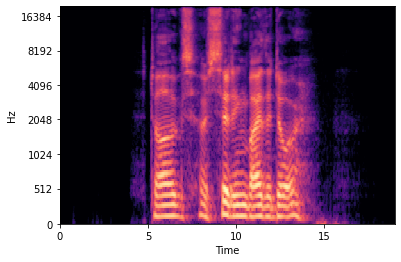

In [10]:
mel_spect = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=1024, hop_length=100)
mel_spect = librosa.power_to_db(mel_spect, ref=np.max)
librosa.display.specshow(mel_spect, y_axis='mel', fmax=20000, x_axis='time');

In [11]:
path_main="/content/drive/My Drive/audio/audio_speech_actors_01-24"


In [12]:
folders_main=os.listdir(path_main)

In [13]:

dicts={'01' : 'neutral', '02' : 'calm', '03' : 'happy', '04' : 'sad', '05' : 'angry', '06' : 'fearful', '07' : 'disgust', '08' : 'surprised'}

In [ ]:
import re

counter=0
for folders in folders_main :
    path_in='/content/drive/My Drive/audio/audio_speech_actors_01-24/{0}'.format(folders)
    files_sub=os.listdir(path_in)
    for file in files_sub :
        numbers = re.findall('\d+',file)
        emotion=dicts[numbers[2]]
        print (numbers[6],emotion)
        path_save='/content/drive/My Drive/sorted_data/{0}/{1}.jpeg'.format(emotion,file)
        path_load='{0}/{1}'.format(path_in,file)
        y, sr = librosa.load(path_load)
        yt,_=librosa.effects.trim(y)
        y=yt
        mel_spect = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=1024, hop_length=100)
        mel_spect = librosa.power_to_db(mel_spect, ref=np.max)
        librosa.display.specshow(mel_spect, y_axis='mel', fmax=20000, x_axis='time');
        plt.savefig(path_save)

01 fearful
01 neutral
01 happy
01 happy
01 calm
01 sad
01 calm
01 sad
01 angry
01 happy
01 fearful
01 calm
01 sad
01 sad
01 angry
01 angry
01 sad
01 fearful
01 happy
01 calm
01 happy
01 calm
01 neutral
01 calm
01 angry
01 sad
01 happy
01 angry
01 angry
01 neutral
01 calm
01 sad
01 neutral
01 calm
01 angry
01 angry
01 happy
01 happy
01 fearful
01 sad
01 disgust
01 fearful
01 surprised
01 disgust
01 disgust
01 fearful
01 surprised
01 disgust
01 surprised
01 fearful
01 surprised
01 disgust
01 surprised
01 surprised
01 fearful
01 disgust
01 disgust
01 disgust
01 surprised
01 surprised
07 calm
07 sad
07 neutral
07 angry
07 fearful
07 happy
07 sad
07 neutral
07 happy
07 angry
07 happy
07 fearful
07 angry
07 angry
07 calm
07 angry
07 fearful
07 angry
07 sad
07 neutral
07 happy
07 happy
07 sad
07 neutral
07 calm
07 disgust
07 calm
07 sad
07 sad
07 fearful
07 fearful
07 angry
07 calm
07 fearful
07 calm
07 calm
07 sad
07 happy
07 happy
07 disgust
07 calm
07 angry
07 fearful
07 happy
07 fearful
0

In [ ]:
re.findall('\d+',file)

['03', '01', '06', '01', '02', '02', '01']

In [ ]:
dicts[numbers[6]]

'neutral'

In [ ]:
print (numbers[6],emotion)


01 fearful


## Data Augmentation




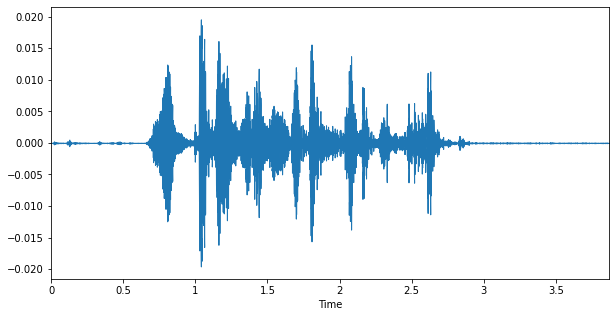

In [ ]:
# MALE SAD ORIGINAL AUDIO FILE
fname = audio + 'Actor_09/03-01-04-02-02-02-09.wav'  
x, sr = librosa.load(fname)
plt.figure(figsize=(10, 5))
librosa.display.waveplot(x, sr=sr)
# plt.title('Waveplot - Male Sad')
# plt.savefig('Waveplot_MaleSad.png')


In [ ]:
# PLAY AUDIO FILE
librosa.output.write_wav("/content/drive/My Drive/ipd.audio_files/MaleSadOriginal.wav", x, sr)
Audio(data=x, rate=sr)

In [ ]:
# FUNCTION TO ADD WHITE NOISE
def noise(x):
    noise_amp = 0.05*np.random.uniform()*np.amax(x)   
    x = x.astype('float64') + noise_amp * np.random.normal(size=x.shape[0])
    return x

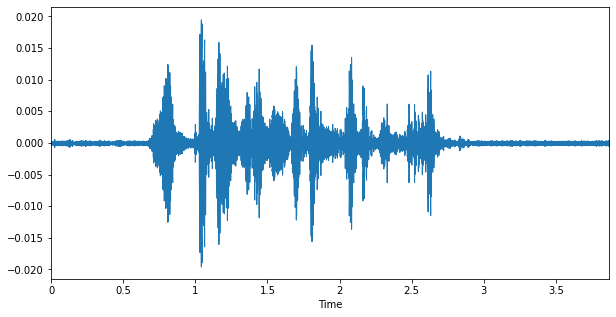

In [ ]:
# ADD NOISE TO MALE SAD ORIGINAL AUDIO FILE
x = noise(x)
plt.figure(figsize=(10, 5))
librosa.display.waveplot(x, sr=sr)
# plt.title('Waveplot - Noise Male Sad')
# plt.savefig('Waveplot_MaleSadNoise.png')

In [ ]:
# PLAY AUDIO FILE
librosa.output.write_wav('/content/drive/My Drive/ipd.audio_files/MaleSadNoise.wav', x, sr)
Audio(data=x, rate=sr)

In [ ]:
# FUNCTION TO STRETCH THE SOUND
def stretch(x, rate=0.8):
    data = librosa.effects.time_stretch(x, rate)
    return data

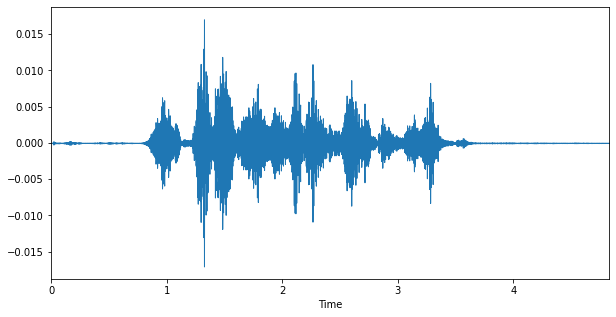

In [ ]:
# ADD STRETCH TO MALE SAD ORIGINAL AUDIO FILE
x = stretch(x)
plt.figure(figsize=(10, 5))
librosa.display.waveplot(x, sr=sr)
# plt.title('Waveplot - Stretch Male Sad')
# plt.savefig('Waveplot_MaleSadStretch.png')

In [ ]:
# PLAY AUDIO FILE
librosa.output.write_wav("/content/drive/My Drive/ipd.audio_files/MaleSadStretch.wav", x, sr)
Audio(data=x, rate=sr)

In [ ]:
# FUNCTION TO INCREASE SPEED AND PITCH 
def speedNpitch(x):
    length_change = np.random.uniform(low=0.8, high = 1)
    speed_fac = 1.4  / length_change 
    tmp = np.interp(np.arange(0,len(x),speed_fac),np.arange(0,len(x)),x)
    minlen = min(x.shape[0], tmp.shape[0])
    x *= 0
    x[0:minlen] = tmp[0:minlen]
    return x

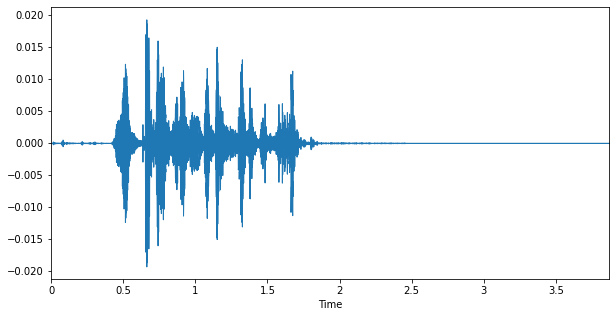

In [ ]:
# ADD SPEED AND PITCH TO MALE SAD ORIGINAL AUDIO FILE
x = speedNpitch(x)
plt.figure(figsize=(10, 5))
librosa.display.waveplot(x, sr=sr)
# plt.title('Waveplot - Speed and Pitch Male Sad')
# plt.savefig('Waveplot_MaleSadSpeedPitch.png')

In [ ]:
# PLAY AUDIO FILE
librosa.output.write_wav('/content/drive/My Drive/ipd.audio_files/MaleSadSpeedPitch.wav', x, sr)
Audio(data=x, rate=sr)

Apply Data Augmentation Methods to Entire Dataset

In [ ]:
# FEATURE EXTRACTION ON RAW AUDIO FILES
df = pd.DataFrame(columns=['log_spec'])
counter=0

for index,path in enumerate(audio_df.path):
    #get wave representation
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=3,sr=44100,offset=0.5)
    
    #get the mel-scaled spectrogram (ransform both the y-axis (frequency) to log scale, and the “color” axis (amplitude) to Decibels, which is kinda the log scale of amplitudes.)
  spectrogram = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128,fmax=8000) 
    db_spec = librosa.power_to_db(spectrogram)
    #temporally average spectrogram
    log_spectrogram = np.mean(db_spec, axis = 0)
    df.loc[counter] = [log_spectrogram]   
    counter += 1
print(len(df))
df.head()

1440


,log_spec
0,"[-73.28034105424189, -73.28034105424189, -73.2..."
1,"[-76.38482267977106, -76.38482267977106, -76.3..."
2,"[-68.53747678613843, -68.64532669270935, -68.5..."
3,"[-74.44398854568155, -74.44398854568155, -74.4..."
4,"[-76.827950353656, -76.827950353656, -76.82795..."


In [ ]:
audio_df.path

0       /content/drive/My Drive/audio/audio_speech_act...
1       /content/drive/My Drive/audio/audio_speech_act...
2       /content/drive/My Drive/audio/audio_speech_act...
3       /content/drive/My Drive/audio/audio_speech_act...
4       /content/drive/My Drive/audio/audio_speech_act...
                              ...                        
1435    /content/drive/My Drive/audio/audio_speech_act...
1436    /content/drive/My Drive/audio/audio_speech_act...
1437    /content/drive/My Drive/audio/audio_speech_act...
1438    /content/drive/My Drive/audio/audio_speech_act...
1439    /content/drive/My Drive/audio/audio_speech_act...
Name: path, Length: 1440, dtype: object

In [ ]:
# ADD NOISE AND USE FEATURE EXTRACTION
df_noise = pd.DataFrame(columns=['feature'])
counter=0
for index,path in enumerate(audio_df.path):
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=3,sr=44100,offset=0.5)
        # noise 
    aug = noise(X)
    aug = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128,fmax=8000)
    db_spec = librosa.power_to_db(aug)
    aug=np.mean(db_spec,axis=0)
    df_noise.loc[counter] = [aug]
    counter +=1
print(len(df_noise))
df_noise.head()

1440


,feature
0,"[-73.28034105424189, -73.28034105424189, -73.2..."
1,"[-76.38482267977106, -76.38482267977106, -76.3..."
2,"[-68.53747678613843, -68.64532669270935, -68.5..."
3,"[-74.44398854568155, -74.44398854568155, -74.4..."
4,"[-76.827950353656, -76.827950353656, -76.82795..."


In [ ]:
# ADD SPEED AND PITCH THEN USE FEATURE EXTRACTION
df_speedpitch = pd.DataFrame(columns=['feature'])
counter=0
for index,path in enumerate(audio_df.path):
    #get wave representation
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=3,sr=44100,offset=0.5)
        # speed pitch
    aug = speedNpitch(X)
    aug = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128,fmax=8000)
    db_spec = librosa.power_to_db(aug)
    aug=np.mean(db_spec,axis=0)
    df_speedpitch.loc[counter] = [aug] 
    counter +=1
print(len(df_speedpitch))
df_speedpitch.head()

1440


,feature
0,"[-74.0959244652167, -74.0959244652167, -74.095..."
1,"[-76.98824315835556, -76.98824315835556, -76.9..."
2,"[-69.34872710797232, -69.35593821841165, -69.2..."
3,"[-75.6467813444487, -75.6467813444487, -75.646..."
4,"[-77.93688521103411, -77.93688521103411, -77.9..."


In [ ]:
# ADD STRETCH AND USE FEATURE EXTRACTION ON AUDIO FILES
df_stretch=pd.DataFrame(columns=['feature'])
counter=0
for index,path in enumerate(audio_df.path):
    #get wave representation
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=3,sr=44100,offset=0.5)
        # stretch
    aug= stretch(X)
    aug = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128,fmax=8000)
    db_spec = librosa.power_to_db(aug)
    aug=np.mean(db_spec,axis=0)
    df_stretch.loc[counter] = [aug] 
    counter +=1
print(len(df_stretch))
df_stretch.head()

1440


,feature
0,"[-73.28034105424189, -73.28034105424189, -73.2..."
1,"[-76.38482267977106, -76.38482267977106, -76.3..."
2,"[-68.53747678613843, -68.64532669270935, -68.5..."
3,"[-74.44398854568155, -74.44398854568155, -74.4..."
4,"[-76.827950353656, -76.827950353656, -76.82795..."


## Combine Tables For Modeling

In [ ]:
# ADD CORRESPONDING EMOTION LABELS TO DF['LOG_SPEC']
mfcc_df = pd.DataFrame(df['log_spec'].values.tolist())
labels = audio_df.emotion
mfcc = pd.concat([mfcc_df,labels], axis=1)
mfcc = mfcc.rename(index=str, columns={"0": "label"})

In [ ]:
# ADD CORRESPONDING EMOTION LABELS TO DF_NOISE['FEATURE']
noise_df = pd.DataFrame(df_noise['feature'].values.tolist())
noise = pd.concat([noise_df,labels], axis=1)
noise = noise.rename(index=str, columns={"0": "label"})

In [ ]:
# ADD CORRESPONDING EMOTION LABELS TO DF_SPEEDPITCH['FEATURE']
speedpitch_df = pd.DataFrame(df_speedpitch['feature'].values.tolist())
speedpitch = pd.concat([speedpitch_df,labels], axis=1)
speedpitch = speedpitch.rename(index=str, columns={"0": "label"})

In [ ]:
# ADD CORRESPONDING EMOTION LABELS TO DF_STRETCH['FEATURE']
stretch_df = pd.DataFrame(df_stretch['feature'].values.tolist())
stretch = pd.concat([stretch_df,labels], axis=1)
stretch = stretch.rename(index=str, columns={"0": "label"})

In [ ]:
# JOIN FOUR DATA FRAMES FOR MODELING
combined_df = pd.concat([mfcc, noise, speedpitch,stretch], ignore_index=True)
combined_df = combined_df.fillna(0)
combined_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,emotion
0,-73.280341,-73.280341,-73.280341,-73.280341,-73.280341,-73.255295,-73.086365,-73.234743,-73.280341,-73.280341,-73.280341,-73.280341,-73.280341,-73.280341,-73.280341,-73.280341,-73.280341,-73.280341,-73.280341,-73.280341,-73.280341,-73.280341,-73.280341,-73.276648,-72.743284,-71.090821,-70.324916,-69.201951,-68.223739,-67.453996,-66.758507,-65.694840,-65.750872,-66.724787,-66.233849,-64.321713,-60.120043,-56.598144,-57.859263,-64.781880,...,-66.120703,-65.074044,-64.953139,-65.560955,-66.357748,-67.087432,-65.717982,-64.857982,-65.405013,-65.109149,-65.750316,-66.323622,-67.260453,-68.170142,-69.806445,-69.922528,-69.255805,-69.982770,-69.889208,-70.506762,-70.457947,-70.751266,-70.714487,-71.486357,-72.600016,-72.950331,-72.629500,-72.750588,-72.966543,-72.866177,-73.029129,-73.022016,-73.157464,-73.278547,-73.280341,-73.272245,-73.042140,-72.969518,-73.264955,fear
1,-76.384823,-76.384823,-76.384823,-76.384823,-76.384823,-76.384823,-76.384823,-76.384823,-76.384823,-76.384823,-76.384823,-76.384823,-76.384823,-76.384823,-76.384823,-76.384823,-76.367504,-76.372107,-76.384823,-76.384823,-76.173958,-75.719145,-75.941572,-75.642659,-75.908988,-75.831011,-75.750751,-74.779811,-72.831309,-71.263080,-66.522703,-66.223528,-70.020485,-72.228969,-72.313721,-73.103126,-73.700781,-74.247387,-72.630097,-70.088718,...,-76.327940,-76.380400,-76.322504,-76.256911,-76.058735,-76.229022,-76.384823,-76.384823,-76.384823,-76.384823,-76.384823,-76.384823,-76.384823,-76.384823,-76.384823,-76.384823,-76.384823,-76.384823,-76.384823,-76.384823,-76.384823,-76.384823,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,neutral
2,-68.537477,-68.645327,-68.528683,-68.425923,-68.655663,-68.790981,-68.813365,-68.790728,-68.810777,-68.842542,-68.842542,-68.842542,-68.842542,-68.842542,-68.842542,-68.842542,-68.842542,-68.842542,-68.842542,-68.842542,-68.842542,-68.842542,-68.804882,-68.800008,-68.641872,-68.604529,-68.720666,-68.842542,-68.842542,-68.842542,-68.842542,-68.842542,-68.842542,-68.842542,-68.842542,-67.576258,-67.635349,-66.775535,-67.080571,-68.756361,...,-67.352828,-67.950188,-67.345036,-66.952429,-67.560323,-67.993375,-68.088957,-67.867515,-67.927142,-67.867477,-67.415718,-67.431667,-68.058387,-68.537010,-68.282271,-68.127357,-68.715035,-68.537438,-68.455786,-68.828202,-68.820989,-68.780663,-68.805177,-68.793758,-68.782453,-68.816873,-68.835131,-68.790415,-68.771058,-68.834982,-68.842542,-68.842542,-68.842542,-68.842542,-68.842542,-68.842542,-68.842542,-68.842542,-68.842542,happy
3,-74.443989,-74.443989,-74.443989,-74.443989,-74.443989,-74.443989,-74.443989,-74.443989,-74.443989,-74.435188,-74.439277,-74.443989,-74.443989,-74.443989,-74.443989,-72.644498,-69.054802,-70.635146,-74.309215,-74.443989,-74.443989,-72.756185,-71.204932,-73.122456,-74.443989,-74.443989,-74.443989,-74.443989,-74.443989,-74.443989,-74.443989,-74.443989,-74.443932,-70.053150,-69.103046,-72.178876,-74.241950,-73.916197,-73.444114,-72.895838,...,-72.297725,-71.753119,-72.903622,-72.637296,-72.912480,-72.703345,-72.366865,-72.145003,-71.630093,-73.283052,-73.782973,-73.294027,-72.736514,-72.862450,-72.838841,-72.089282,-72.229188,-72.704804,-73.004429,-72.288628,-72.106903,-72.890192,-73.753686,-74.342151,-74.162344,-74.027233,-73.811514,-74.196151,-74.006761,-73.833332,-74.242039,-74.166452,-74.279108,-74.315124,-74.067950,-73.994041,-74.321761,-74.347929,-74.377555,happy
4,-76.827950,-76.827950,-76.827950,-76.827950,-76.827950,-76.827950,-76.651116,-76.677450,-76.827950,-76.827950,-76.827950,-76.827950,-76.827950,-76.827950,-76.827950,-76.804439,-76.532114,-76.449238,-76.649428,-76.827950,-76.8279

In [ ]:
combined_df.shape

(5760, 260)

In [ ]:
mfcc.shape

(1440, 260)

In [ ]:
noise.shape

(1440, 260)

In [ ]:
speedpitch.shape

(1440, 260)

In [ ]:
stretch.shape

(1440, 260)

## CNN

In [ ]:

# making our data compatible to model.
X_train = np.expand_dims(X_train, axis=3)
X_test = np.expand_dims(X_test, axis=3)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

AxisError: ignored

In [ ]:
# STRATIFIED SHUFFLE SPLIT TO HANDLE CLASS IMBALANCE
X = combined_df.drop(['emotion'], axis=1)
y = combined_df.emotion
SSS = StratifiedShuffleSplit(1, test_size=0.25, random_state=12)
for train_index, test_index in SSS.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [ ]:
y_train.value_counts()

angry       576
calm        576
disgust     576
surprise    576
sad         576
happy       576
fear        576
neutral     288
Name: emotion, dtype: int64

In [ ]:
y_test.value_counts()

angry       192
calm        192
surprise    192
sad         192
disgust     192
happy       192
fear        192
neutral      96
Name: emotion, dtype: int64

In [ ]:
# NORMALIZE DATA
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)
X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

In [ ]:
# TURN INTO ARRAYS
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [ ]:
# ONE HOT ENCODE EMOTION LABELS
lb = LabelEncoder()
y_train = to_categorical(lb.fit_transform(y_train))
y_test = to_categorical(lb.fit_transform(y_test))

print(y_test[0:10])

[[0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]]


In [ ]:
print(lb.classes_)

['angry' 'calm' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']


In [ ]:
# RESHAPE TO ADD 3D TENSOR FOR 1D CNN INPUT
X_train = X_train[:,:,np.newaxis]
X_test = X_test[:,:,np.newaxis]
X_test.shape

(1440, 259, 1)

In [ ]:
# BUILD 1D CNN LAYERS
model = Sequential()
model.add(Conv1D(64, kernel_size=(20), activation='relu', input_shape=(X_train.shape[1],1)))
model.add(Conv1D(128, kernel_size=(20),activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Dropout(0.4))
model.add(Conv1D(128, kernel_size=(20),activation='relu'))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(8, activation='softmax'))
model.summary()
opt = keras.optimizers.Adam(lr=0.0001)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 240, 64)           1344      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 221, 128)          163968    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 27, 128)           0         
_________________________________________________________________
dropout (Dropout)            (None, 27, 128)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 8, 128)            327808    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1, 128)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 128)            0

In [ ]:
# FIT MODEL AND SAVE BEST MODEL BASED ON VAL_ACCURACY
checkpoint = ModelCheckpoint("best_aug_model.hdf5", monitor='val_accuracy', verbose=1,
    save_best_only=True, mode='max', period=1, save_weights_only=True)


model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
model_history=model.fit(X_train, y_train,batch_size=32, epochs=40, validation_data=(X_test, y_test))




Epoch 1/40
135/135 [==============================] - 2s 14ms/step - loss: 1.3270 - accuracy: 0.5100 - val_loss: 1.2923 - val_accuracy: 0.5396
Epoch 2/40
135/135 [==============================] - 2s 12ms/step - loss: 1.3087 - accuracy: 0.5213 - val_loss: 1.2838 - val_accuracy: 0.5382
Epoch 3/40
135/135 [==============================] - 2s 12ms/step - loss: 1.2925 - accuracy: 0.5306 - val_loss: 1.2532 - val_accuracy: 0.5458
Epoch 4/40
135/135 [==============================] - 2s 12ms/step - loss: 1.2861 - accuracy: 0.5407 - val_loss: 1.2466 - val_accuracy: 0.5556
Epoch 5/40
135/135 [==============================] - 2s 12ms/step - loss: 1.2662 - accuracy: 0.5352 - val_loss: 1.2213 - val_accuracy: 0.5681
Epoch 6/40
135/135 [==============================] - 2s 12ms/step - loss: 1.2489 - accuracy: 0.5463 - val_loss: 1.2255 - val_accuracy: 0.5785
Epoch 7/40
135/135 [==============================] - 2s 12ms/step - loss: 1.2220 - accuracy: 0.5569 - val_loss: 1.2109 - val_accuracy: 0.5660

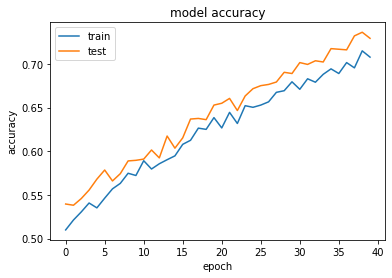

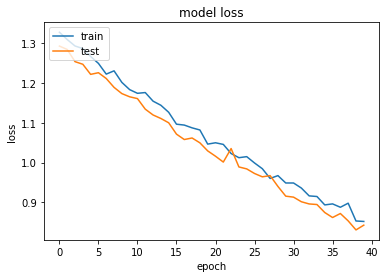

In [ ]:
# PRINT MODEL HISTORY OF ACCURACY AND LOSS OVER EPOCHS
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
# plt.savefig('Augmented_Model_Accuracy.png')
plt.show()
# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
# plt.savefig('Augmented_Model_Loss.png')
plt.show()

In [ ]:
# PREDICTION LABELS
predictions = model.predict(X_test, batch_size=32)
predictions=predictions.argmax(axis=1)
predictions
predictions = predictions.astype(int).flatten()
predictions = (lb.inverse_transform((predictions)))
predictions = pd.DataFrame({'Predicted Values': predictions})

# ACTUAL LABELS
actual=y_test.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (lb.inverse_transform((actual)))
actual = pd.DataFrame({'Actual Values': actual})

# COMBINE PREDICTION AND ACTUAL LABELS
finaldf = actual.join(predictions)
finaldf[140:150]

,Actual Values,Predicted Values
140,sad,sad
141,calm,calm
142,fear,fear
143,disgust,sad
144,surprise,disgust
145,disgust,disgust
146,fear,angry
147,sad,sad
148,happy,neutral
149,calm,neutral


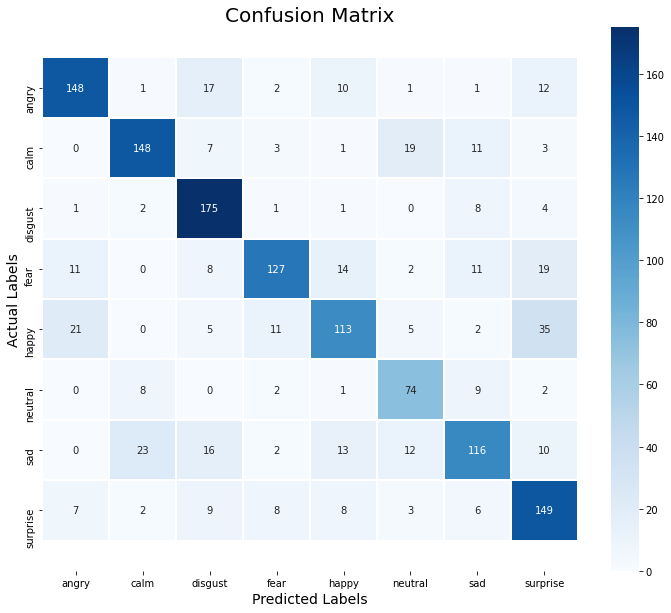

In [ ]:
# CREATE CONFUSION MATRIX OF ACTUAL VS. PREDICTION 
cm = confusion_matrix(actual, predictions)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in lb.classes_] , columns = [i for i in lb.classes_])
ax = sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
# plt.savefig('Augmented_Model_Confusion_Matrix.png')
plt.show()

In [ ]:
print(classification_report(actual, predictions, target_names = ['angry','calm','disgust','fear','happy','neutral','sad','surprise']))

              precision    recall  f1-score   support

       angry       0.79      0.77      0.78       192
        calm       0.80      0.77      0.79       192
     disgust       0.74      0.91      0.82       192
        fear       0.81      0.66      0.73       192
       happy       0.70      0.59      0.64       192
     neutral       0.64      0.77      0.70        96
         sad       0.71      0.60      0.65       192
    surprise       0.64      0.78      0.70       192

    accuracy                           0.73      1440
   macro avg       0.73      0.73      0.73      1440
weighted avg       0.73      0.73      0.73      1440



In [ ]:
pip install torchvision


In [ ]:
from torchvision import models
import torch

dir(models)

In [ ]:
alexnet = models.alexnet(pretrained=True)


Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth


In [ ]:
print(alexnet)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
from keras.applications import vgg16
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import VGG16


img_rows, img_cols = 224, 224

model = vgg16.VGG16(weights= 'imagenet', include_top=False, input_shape= (1440, 259, 1))

ValueError: ignored

In [ ]:
X_train.shape

(4320, 259, 1)

In [ ]:
# freezing the layers 
for layer in model.layers:
    layer.trainable = False

In [ ]:
model.summary()


In [ ]:
X_train = X_train.reshape(-1,1440,259,1)

In [ ]:

# adding additional layers for hyperparameter tuning

def layer_adder(bottom_model, num_classes):
    top_model = bottom_model.output
    # top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024, activation='relu')(top_model)
    top_model = Dense(512, activation='relu')(top_model)
    top_model = Dense(8, activation='softmax')(top_model)
    return top_model

In [ ]:
# pulling together the entire model
from keras.layers import GlobalAveragePooling2D

num_classes = 1

FC_Head = layer_adder(model, num_classes)

model = Model(inputs = model.input, outputs = FC_Head)

print(model.summary())

In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics= ['accuracy'])


epochs = 10
batch_size = 16

history = model.fit(X_train, y_train, epochs= epochs, validation_data= (X_test,y_test))

In [ ]:
def load_audio_file(file_path, input_length=input_length):
    data = librosa.core.load(file_path, sr=16000)[0] #, sr=16000
    if len(data)>input_length:
        
        
        max_offset = len(data)-input_length
        
        offset = np.random.randint(max_offset)
        
        data = data[offset:(input_length+offset)]
        
        
    else:
        if input_length > len(data):
            max_offset = input_length - len(data)

            offset = np.random.randint(max_offset)
        else:
            offset = 0
        
        
        data = np.pad(data, (offset, input_length - len(data) - offset), "constant")
        
        
    data = preprocess_audio_mel_T(data)
    return data


# In[3]:


train_files = glob.glob("../input/audio_train/*.wav")
test_files = glob.glob("../input/audio_test/*.wav")
train_labels = pd.read_csv("../input/train.csv")


# In[4]:


file_to_label = {"../input/audio_train/"+k:v for k,v in zip(train_labels.fname.values, train_labels.label.values)}


# In[5]:


#file_to_label


# In[7]:

#
# data_base = load_audio_file(train_files[0])
# fig = plt.figure(figsize=(14, 8))
# plt.title('Raw wave : %s ' % (file_to_label[train_files[0]]))
# plt.ylabel('Amplitude')
# plt.plot(np.linspace(0, 1, input_length), data_base)
# plt.show()


# In[8]:


list_labels = sorted(list(set(train_labels.label.values)))


# In[9]:


label_to_int = {k:v for v,k in enumerate(list_labels)}


# In[10]:


int_to_label = {v:k for k,v in label_to_int.items()}


# In[11]:


file_to_int = {k:label_to_int[v] for k,v in file_to_label.items()}


In [ ]:
# making our data compatible to model.
X_train = np.expand_dims(X_train, axis=3)
X_test = np.expand_dims(X_test, axis=3)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((4320, 259, 1, 1, 1), (4320, 8), (1440, 259, 1, 1, 1), (1440, 8))

# MFCC
### The mel frequency cepstral coefficients (MFCCs) of a signal are a small set of features (usually about 10–20) which concisely describe the overall shape of a spectral envelope. MFCC is a good "representation" of the vocal tract that produces the sound. Think of it like an x-ray of your mouth

In [ ]:
fa_mfcc = librosa.feature.mfcc(y=data_neutral, sr=sr_neutral, n_mfcc=13)
plt.figure(figsize=(15, 10))
plt.subplot(3,1,1)
librosa.display.specshow(fa_mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

In [ ]:
# MFCC
#The mel frequency cepstral coefficients (MFCCs) of a signal are a small set of features 
#(usually about 10–20) which concisely describe the overall shape of a spectral envelope.
# good "representation" of the vocal tract that produces the sound. Think of it like an 
# x-ray of your mouth
mfcc = librosa.feature.mfcc(y=data, sr=sampling_rate, n_mfcc=13)

plt.figure(figsize=(15, 10))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar();

In [ ]:
mfcc.shape

216
216
216
216


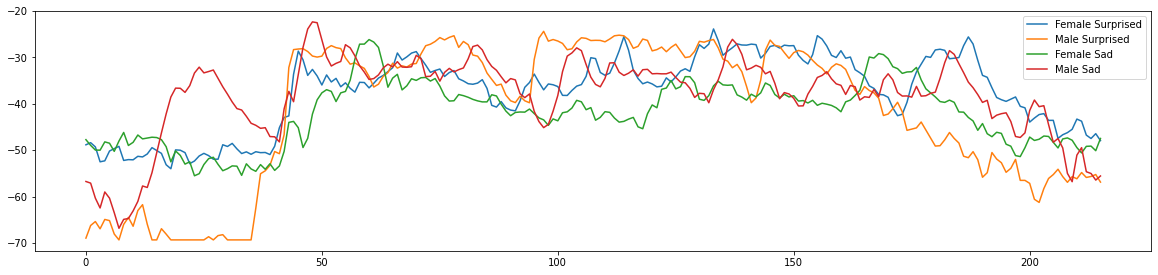

In [ ]:
# Male surprised
pathh = audio + 'Actor_09/03-01-08-02-02-02-09.wav'
X, sample_rate = librosa.load(pathh, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
male = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
male = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
print(len(male))

# Female surprised
path= audio + 'Actor_08/03-01-08-02-02-02-08.wav'
X, sample_rate = librosa.load(path,duration=2.5,sr=22050*2,offset=0.5)
female = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
female = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
print(len(female))

# Male sad
pathh = audio + 'Actor_09/03-01-04-02-02-02-09.wav'
X, sample_rate = librosa.load(pathh, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
male1 = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
male1 = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
print(len(male1))

# Female sad
path= audio + 'Actor_08/03-01-04-02-02-02-08.wav'
X, sample_rate = librosa.load(path,duration=2.5,sr=22050*2,offset=0.5)
female1 = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
female1 = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
print(len(female1))

plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
plt.plot(female, label='Female Surprised')
plt.plot(male, label='Male Surprised')
plt.plot(female1, label='Female Sad')
plt.plot(male1, label='Male Sad')
plt.legend()



In [ ]:
# Spectrogram - how the audio spectrum varies as a function of time
spectrogram = librosa.feature.melspectrogram(y=X, sr=sampling_rate)
db_spec = librosa.power_to_db(spectrogram, ref=np.max,)
librosa.display.specshow(db_spec,y_axis='mel', x_axis='time', sr=sampling_rate)
plt.colorbar();

## Feature Extraction

In [ ]:
df = pd.DataFrame(columns=['mfcc_feature'])

counter=0

for index,path in enumerate(audio_df.path):
    #get wave representation
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=3,sr=44100,offset=0.5)
        
    #Mel-frequency cepstral coefficients (MFCCs)
    mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
    #temporal averaging
    mfcc=np.mean(mfcc,axis=0)

    
    # #get the mel-scaled spectrogram ()
    # spectrogram = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128,fmax=8000)  
    # #temporally average spectrogram
    # spectrogram = np.mean(spectrogram, axis = 0)
    
    # #compute chroma energy (pertains to 12 different pitch classes)
    # chroma = librosa.feature.chroma_stft(y=X, sr=sample_rate)
    # #temporally average chroma
    # chroma = np.mean(chroma, axis = 0)
    
    # #compute spectral contrast
    # contrast = librosa.feature.spectral_contrast(y=X, sr=sample_rate)
    # contrast = np.mean(contrast, axis= 0)

    # compute zero-crossing-rate (zcr:the zcr is the rate of sign changes along a signal i.e.m the rate at 
    # which the signal changes from positive to negative or back - separation of voiced andunvoiced speech.)
    # zcr = librosa.feature.zero_crossing_rate(y=X)
    # zcr = np.mean(zcr, axis= 0)
    
    df.loc[counter] = [mfcc]
    counter=counter+1   

print(len(df))
df.head()

1440


,mfcc_feature
0,"[-63.52352959684379, -63.52352959684379, -63.5..."
1,"[-65.8009712673087, -65.8009712673087, -65.800..."
2,"[-58.73100684143704, -58.74653122015798, -58.0..."
3,"[-65.24334603230012, -65.24334603230012, -65.2..."
4,"[-67.55739512198222, -67.55739512198222, -67.5..."


In [ ]:
print (mfcc.mean(axis=1))
print (mfcc.var(axis=1))

IndexError: ignored

In [ ]:
df.columns

Index(['mfcc_feature', 'spec_feat', 'chroma_feat', 'contrast_feat'], dtype='object')

In [ ]:
df = pd.DataFrame(columns=['mfcc_feature'])

# feature extraction over the entire dataset
counter=0
for index,path in enumerate(audio_df.path):
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=44100,offset=0.5)
    sample_rate = np.array(sample_rate)
    
    mfcc = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13),axis=0)
    df.loc[counter] = [mfccs]
    counter=counter+1   


print(len(df))
df.head()


NameError: ignored

In [ ]:
df_chroma = pd.DataFrame(columns=['chroma_feat'])

# feature extraction over the entire dataset
counter=0
for index,path in enumerate(audio_df.path):
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=44100,offset=0.5)
    sample_rate = np.array(sample_rate)
    
    chroma=np.mean(librosa.feature.chroma_stft(X, sr=sample_rate).T,axis=0)
    df_chroma.loc[counter] = [chroma]
    counter=counter+1   


print(len(df_chroma))
df_chroma.head()

In [ ]:
# rmse = librosa.feature.rmse(y=y)
# spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr) : DO NOT USE - INDICATES WHERE CENTER OF MASS IS, IS THE SAME FOR HAPPY AND SURPRISED
# spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
# rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
# zcr = librosa.feature.zero_crossing_rate(y)

## CNN

In [ ]:
# Extract the mean bands to its own feature columns
df_combined = pd.concat([audio_df,pd.DataFrame(df['mfcc_feature'].values.tolist()),
                        #  pd.DataFrame(df['chroma_feat'].values.tolist()),
                        #  pd.DataFrame(df['spec_feat'].values.tolist())
                         ],axis=1)
df_combined = df_combined.fillna(0)

In [ ]:
df_combined.drop(columns='gender',inplace=True)

In [ ]:
df_combined.head()

,emotion,path,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,...,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258
0,fear,/content/drive/My Drive/audio/audio_speech_act...,-63.523530,-63.523530,-63.523530,-63.523530,-63.523530,-63.377373,-61.595853,-63.160227,-63.523530,-63.523530,-63.523530,-63.523530,-63.523530,-63.523530,-63.523530,-63.523530,-63.523530,-63.523530,-63.523530,-63.523530,-63.523530,-63.523530,-63.523530,-63.486761,-63.453534,-60.923158,-58.164801,-58.033787,-57.377220,-58.619264,-57.489921,-57.051144,-58.815463,-59.090078,-58.199690,-57.456970,-53.362825,-48.075103,...,9.470058e-06,2.578390e-05,2.461057e-05,1.202463e-05,5.154764e-06,2.293928e-06,8.568837e-07,1.537127e-06,2.078454e-06,2.184434e-06,3.041122e-06,1.803422e-06,1.143403e-06,7.627434e-07,3.888000e-07,1.779640e-07,1.923068e-07,3.168509e-07,2.245657e-07,2.101146e-07,1.500544e-07,1.671772e-07,1.471501e-07,1.313681e-07,8.375042e-08,3.572479e-08,2.370430e-08,3.129491e-08,2.816052e-08,2.174507e-08,2.531549e-08,1.924894e-08,1.741787e-08,1.225668e-08,7.529888e-09,5.454092e-09,6.819510e-09,1.796941e-08,1.751192e-08,7.574554e-09
1,neutral,/content/drive/My Drive/audio/audio_speech_act...,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.793168,-65.800971,-65.800971,-65.800971,-63.896145,-60.063347,-61.391446,-59.506572,-61.304348,-60.479436,-59.622011,-59.312969,-56.807714,-57.467487,-54.780278,-54.338120,-56.671499,-56.021689,-55.159339,-55.876813,-56.127683,-56.435845,...,3.132524e-09,2.293366e-09,1.289942e-09,3.135538e-09,4.808926e-09,9.926860e-09,4.514360e-09,3.569078e-10,3.039941e-10,4.092756e-10,2.502424e-10,8.785423e-11,4.097390e-10,3.496092e-10,8.525146e-11,9.268422e-11,2.479107e-11,1.047995e-10,6.573235e-10,1.409621e-09,3.839809e-10,9.462552e-12,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2,happy,/content/drive/My Drive/audio/audio_speech_act...,-58.731007,-58.746531,-58.048578,-57.370804,-58.199914,-59.706633,-59.876183,-59.998060,-59.936650,-60.248568,-60.248568,-60.248568,-60.248568,-60.248568,-60.248568,-60.248568,-60.248568,-60.248568,-60.248568,-60.248568,-60.248568,-60.248568,-60.249521,-60.257292,-57.940615,-57.685275,-58.743272,-60.248568,-60.248568,-60.248568,-60.248568,-60.248568,-60.248568,-60.248568,-60.248568,-59.475713,-59.103223,-56.911964,...,2.422831e-07,1.714550e-07,1.098402e-07,1.919263e-07,2.688476e-07,1.465773e-07,1.096860e-07,9.550388e-08,1.298970e-07,1.184836e-07,1.274261e-07,2.088348e-07,1.981786e-07,1.049217e-07,5.793580e-08,7.813114e-08,8.910524e-08,3.787632e-08,4.967923e-08,5.793108e-08,2.227009e-08,2.370553e-08,2.333633e-08,1.691262e-08,1.855947e-08,2.228112e-08,1.963106e-08,1.471574e-08,2.673383e-08,2.712630e-08,1.231842e-08,7.812410e-09,7.712507e-10,7.638044e-10,1.757530e-09,2.919100e-09,8.747867e-10,4.573883e-10,5.310010e-10,7.820663e-11
3,happy,/content/drive/My Drive/audio/audio_speech_act...,-65.243346,-65.243346,-65.243346,-65.243346,-65.243346,-65.243346,-65.243346,-65.243346,-65.243346,-65.117574,-65.243346,-65.243346,-65.243346,-65.243346,-65.243346,-64.744637,-59.645945,-62.325064,-65.276450,-65.243346,-65.243577,-63.977965,-62.763801,-64.460970,-65.243346,-65.243346,-65.243346,-65.243346,-65.243346,-65.243346,-65.243346,-65.243346,-65.235624,-62.331518,-61.644450,-63.583881,-64.115173,-61.981372,...,1.324463e-07,1.342138e-07,2.391723e-07,1.658444e-07,1.556888e-07,1.030683e-07,1.267966e-07,1.693123e-07,1.926444e-07,1.948504e-07,5.296063e-08,3.158196e-08,5.809344e-08,1.287589e-07,1.516797e-07,2.053868e-07,4.422756e-07,3.753533e-07,2.2

In [ ]:
# Extract the mean bands to its own feature columns
df = pd.concat([audio_df,pd.DataFrame(df['mfcc_feature'].values.tolist())],axis=1)
df=df.fillna(0)

In [ ]:
df_combined.head()

,emotion,path,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,...,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258
0,fear,/content/drive/My Drive/audio/audio_speech_act...,-63.523530,-63.523530,-63.523530,-63.523530,-63.523530,-63.377373,-61.595853,-63.160227,-63.523530,-63.523530,-63.523530,-63.523530,-63.523530,-63.523530,-63.523530,-63.523530,-63.523530,-63.523530,-63.523530,-63.523530,-63.523530,-63.523530,-63.523530,-63.486761,-63.453534,-60.923158,-58.164801,-58.033787,-57.377220,-58.619264,-57.489921,-57.051144,-58.815463,-59.090078,-58.199690,-57.456970,-53.362825,-48.075103,...,9.470058e-06,2.578390e-05,2.461057e-05,1.202463e-05,5.154764e-06,2.293928e-06,8.568837e-07,1.537127e-06,2.078454e-06,2.184434e-06,3.041122e-06,1.803422e-06,1.143403e-06,7.627434e-07,3.888000e-07,1.779640e-07,1.923068e-07,3.168509e-07,2.245657e-07,2.101146e-07,1.500544e-07,1.671772e-07,1.471501e-07,1.313681e-07,8.375042e-08,3.572479e-08,2.370430e-08,3.129491e-08,2.816052e-08,2.174507e-08,2.531549e-08,1.924894e-08,1.741787e-08,1.225668e-08,7.529888e-09,5.454092e-09,6.819510e-09,1.796941e-08,1.751192e-08,7.574554e-09
1,neutral,/content/drive/My Drive/audio/audio_speech_act...,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.793168,-65.800971,-65.800971,-65.800971,-63.896145,-60.063347,-61.391446,-59.506572,-61.304348,-60.479436,-59.622011,-59.312969,-56.807714,-57.467487,-54.780278,-54.338120,-56.671499,-56.021689,-55.159339,-55.876813,-56.127683,-56.435845,...,3.132524e-09,2.293366e-09,1.289942e-09,3.135538e-09,4.808926e-09,9.926860e-09,4.514360e-09,3.569078e-10,3.039941e-10,4.092756e-10,2.502424e-10,8.785423e-11,4.097390e-10,3.496092e-10,8.525146e-11,9.268422e-11,2.479107e-11,1.047995e-10,6.573235e-10,1.409621e-09,3.839809e-10,9.462552e-12,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2,happy,/content/drive/My Drive/audio/audio_speech_act...,-58.731007,-58.746531,-58.048578,-57.370804,-58.199914,-59.706633,-59.876183,-59.998060,-59.936650,-60.248568,-60.248568,-60.248568,-60.248568,-60.248568,-60.248568,-60.248568,-60.248568,-60.248568,-60.248568,-60.248568,-60.248568,-60.248568,-60.249521,-60.257292,-57.940615,-57.685275,-58.743272,-60.248568,-60.248568,-60.248568,-60.248568,-60.248568,-60.248568,-60.248568,-60.248568,-59.475713,-59.103223,-56.911964,...,2.422831e-07,1.714550e-07,1.098402e-07,1.919263e-07,2.688476e-07,1.465773e-07,1.096860e-07,9.550388e-08,1.298970e-07,1.184836e-07,1.274261e-07,2.088348e-07,1.981786e-07,1.049217e-07,5.793580e-08,7.813114e-08,8.910524e-08,3.787632e-08,4.967923e-08,5.793108e-08,2.227009e-08,2.370553e-08,2.333633e-08,1.691262e-08,1.855947e-08,2.228112e-08,1.963106e-08,1.471574e-08,2.673383e-08,2.712630e-08,1.231842e-08,7.812410e-09,7.712507e-10,7.638044e-10,1.757530e-09,2.919100e-09,8.747867e-10,4.573883e-10,5.310010e-10,7.820663e-11
3,happy,/content/drive/My Drive/audio/audio_speech_act...,-65.243346,-65.243346,-65.243346,-65.243346,-65.243346,-65.243346,-65.243346,-65.243346,-65.243346,-65.117574,-65.243346,-65.243346,-65.243346,-65.243346,-65.243346,-64.744637,-59.645945,-62.325064,-65.276450,-65.243346,-65.243577,-63.977965,-62.763801,-64.460970,-65.243346,-65.243346,-65.243346,-65.243346,-65.243346,-65.243346,-65.243346,-65.243346,-65.235624,-62.331518,-61.644450,-63.583881,-64.115173,-61.981372,...,1.324463e-07,1.342138e-07,2.391723e-07,1.658444e-07,1.556888e-07,1.030683e-07,1.267966e-07,1.693123e-07,1.926444e-07,1.948504e-07,5.296063e-08,3.158196e-08,5.809344e-08,1.287589e-07,1.516797e-07,2.053868e-07,4.422756e-07,3.753533e-07,2.2

In [ ]:
from sklearn.model_selection import train_test_split

# TRAIN TEST SPLIT
X_model, X_test, y_model, y_test = train_test_split(df_combined.drop(['path','emotion'],axis=1)
                                                    , df_combined.emotion
                                                    , test_size=0.25
                                                    , shuffle=True
                                                    , random_state=42
                                                    , stratify = df_combined.emotion
                                                   )



In [ ]:
# TRAIN TEST SPLIT
X_train, X_validation, y_train, y_validation = train_test_split(X_model
                                                    , y_model
                                                    , test_size=0.25
                                                    , shuffle=True
                                                    , random_state=42
                                                    , stratify = y_model
                                                   )


In [ ]:
df_combined[df_combined.index.duplicated()]



,emotion,path,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,...,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258


In [ ]:
#Data normalization 
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean)/std
X_test = (X_test - mean)/std
X_validation = (X_validation - mean)/std

# Check the dataset now 
X_train[150:160]

TypeError: ignored

In [ ]:
len(X_train)

810

In [ ]:
# Lets few preparation steps to get it into the correct format for Keras 
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
X_validation = np.array(X_validation)
y_validation = np.array(y_validation)

In [ ]:
y_test

array(['calm', 'happy', 'neutral', 'happy', 'calm', 'happy', 'calm',
       'neutral', 'calm', 'calm', 'happy', 'happy', 'happy', 'calm',
       'calm', 'calm', 'neutral', 'sad', 'happy', 'neutral', 'happy',
       'disgust', 'sad', 'surprise', 'angry', 'angry', 'fear', 'disgust',
       'fear', 'disgust', 'angry', 'angry', 'disgust', 'fear', 'surprise',
       'surprise', 'disgust', 'disgust', 'surprise', 'sad', 'sad',
       'surprise', 'fear', 'sad', 'angry', 'sad', 'surprise', 'fear',
       'disgust', 'fear', 'surprise', 'angry', 'fear', 'fear', 'disgust',
       'surprise', 'angry', 'sad', 'sad', 'angry', 'neutral', 'neutral',
       'calm', 'calm', 'calm', 'happy', 'neutral', 'calm', 'calm', 'calm',
       'calm', 'calm', 'neutral', 'happy', 'disgust', 'fear', 'surprise',
       'fear', 'disgust', 'sad', 'sad', 'happy', 'angry', 'disgust',
       'happy', 'sad', 'fear', 'happy', 'angry', 'angry', 'angry', 'fear',
       'surprise', 'happy', 'sad', 'fear', 'surprise', 'surprise',

In [ ]:
len(y_train)

810

In [ ]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils, to_categorical

# # one hot encode the target 
# CNN requires input and output are numbers
lb = LabelEncoder()
y_train = lb.fit_transform(y_train)
y_train = to_categorical(y_train)
y_test = lb.fit_transform(y_test)
y_test = to_categorical(y_test)
y_validation = lb.fit_transform(y_validation)
y_validation = to_categorical(y_validation)
print(y_train[0:10])


# lb = LabelEncoder()
# y_train = to_categorical(lb.fit_transform(y_train))
# y_test = to_categorical(lb.fit_transform(y_test))
# print(y_train[0:10])

# # # one hot encode the target 
# lb = LabelEncoder()
# y_train = np_utils.to_categorical(lb.fit_transform(y_train))
# y_test = np_utils.to_categorical(lb.fit_transform(y_test))
# print(y_train[0:10])



[[0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]]


In [ ]:
print(lb.classes_)

['angry' 'calm' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']


In [ ]:
#time series data requires kernel sliding in only one dimension and have spatial properties
X_train = X_train[:,:,np.newaxis]
X_test = X_test[:,:,np.newaxis]
X_validation = X_validation[:,:,np.newaxis]

# X_train = np.expand_dims(X_train, axis=2)
# X_test = np.expand_dims(X_test, axis=2)
# X_train.shape

In [ ]:
y_train.shape

In [ ]:
import keras
from keras.models import Sequential, Model, model_from_json
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Dense, Embedding, LSTM

# model = Sequential()
# model.add(Conv1D(32, kernel_size=(3), activation='relu', input_shape=(X_train.shape[1],1)))
# model.add(Conv1D(64, kernel_size=(3), activation='relu'))
# model.add(MaxPooling1D(pool_size=(2)))
# model.add(Conv1D(128, kernel_size=(4), activation='relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling1D(pool_size=(2)))
# model.add(Dropout(0.25))
# model.add(Conv1D(64, kernel_size=(3), activation='relu'))
# model.add(MaxPooling1D(pool_size=(2)))
# model.add(Dropout(0.25))
# model.add(Conv1D(128, kernel_size=(3), activation='relu'))
# model.add(MaxPooling1D(pool_size=(2)))
# model.add(Dropout(0.25))
# model.add(Conv1D(128, kernel_size=(3), activation='relu'))
# model.add(MaxPooling1D(pool_size=(2)))
# model.add(Flatten())
# model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(8, activation='softmax'))
# model.summary()
# opt = keras.optimizers.Adam(lr=0.0001)



model = Sequential()
model.add(Conv1D(64, 8, padding='same',input_shape=(X_train.shape[1],1)))  # X_train.shape[1] = No. of Columns
model.add(Activation('relu'))
model.add(Conv1D(64, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(256, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(256, 8, padding='same'))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(8)) # Target class number
model.add(Activation('softmax'))
# opt = keras.optimizers.SGD(lr=0.0001, momentum=0.0, decay=0.0, nesterov=False)
# opt = keras.optimizers.Adam(lr=0.0001)
opt = keras.optimizers.RMSprop(lr=0.00001, decay=1e-6)
model.summary()

Model: "sequential_346"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1733 (Conv1D)         (None, 777, 64)           576       
_________________________________________________________________
activation_31 (Activation)   (None, 777, 64)           0         
_________________________________________________________________
conv1d_1734 (Conv1D)         (None, 777, 64)           32832     
_________________________________________________________________
batch_normalization_10 (Batc (None, 777, 64)           256       
_________________________________________________________________
activation_32 (Activation)   (None, 777, 64)           0         
_________________________________________________________________
dropout_1373 (Dropout)       (None, 777, 64)           0         
_________________________________________________________________
max_pooling1d_1373 (MaxPooli (None, 97, 64)         

In [ ]:
batch_size=1
epochs=50

In [ ]:
val_loss_thresh = 4.00

class myCallback(tf.keras.callbacks.Callback): 
    def on_epoch_end(self, epoch, logs={}): 
        if(logs.get('val_loss') > val_loss_thresh):   
          print("\nWe have reached %2.2f%% val_loss, so we will stopping training.")   
        self.model.stop_training = True
callbacks = myCallback()


In [ ]:
# categorical crossentropy since output variable has more than 2 label classes

# model.compile(loss='sparse_categorical_crossentropy',
#                       optimizer='rmsprop',
#                       metrics=['accuracy'])
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
model_history=model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_validation, y_validation),callbacks=[callbacks])

Epoch 1/50
810/810 [==============================] - 27s 34ms/step - loss: 1.3590 - accuracy: 0.5049 - val_loss: 1.7924 - val_accuracy: 0.2926


In [ ]:
print("Loss of the model is - " , model.evaluate(X_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(X_test,y_test)[1]*100 , "%")

12/12 [==============================] - 1s 49ms/step - loss: 4.6382 - accuracy: 0.3528
Loss of the model is -  4.638173580169678
12/12 [==============================] - 1s 51ms/step - loss: 4.6382 - accuracy: 0.3528
Accuracy of the model is -  35.277777910232544 %


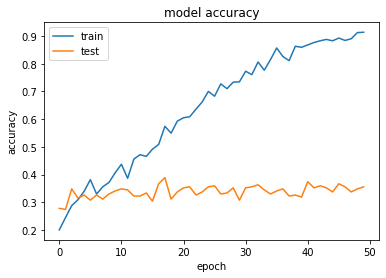

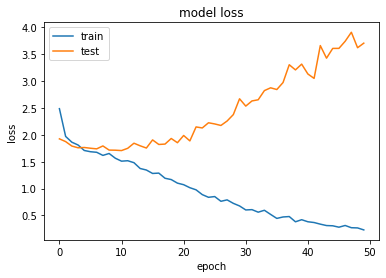

In [ ]:
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
#100 epoch
# accuracy: .8620, 38.88
# 0.7935, loss:1.88, 41.94

In [ ]:
# 50 epoch
# val_accuracy = .3972 mfcc
      # .3722 mfcc
# val_accuracy = 0.2139 chroma
# val_accuracy = 0.0639 mfcc + chroma
# 50 epoch - changed random_state
# val_accuracy

In [ ]:
# def extract_feature(file_name, mfcc, chroma, mel):
#     with soundfile.SoundFile(file_name) as sound_file:
#         X = sound_file.read(dtype="float32")
#         sample_rate=sound_file.samplerate
#         if chroma:
#             stft=np.abs(librosa.stft(X))
#         result=np.array([])
#         if mfcc:
#             mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
#             result=np.hstack((result, mfccs))
#         if chroma:
#             chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
#             result=np.hstack((result, chroma))
#         if mel:
#             mel=np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
#             result=np.hstack((result, mel))

DATA AUGMENTATION

In [ ]:
pre_aug= pd.read_csv('audio.csv',usecols=['emotion','path'])
pre_aug.head()

,emotion,path
0,fear,/content/drive/My Drive/audio/audio_speech_act...
1,neutral,/content/drive/My Drive/audio/audio_speech_act...
2,happy,/content/drive/My Drive/audio/audio_speech_act...
3,happy,/content/drive/My Drive/audio/audio_speech_act...
4,calm,/content/drive/My Drive/audio/audio_speech_act...


In [ ]:
from tqdm import tqdm


In [ ]:
def speedNpitch(data):
    """
    peed and Pitch Tuning.
    """
    # you can change low and high here
    length_change = np.random.uniform(low=0.8, high = 1)
    speed_fac = 1.2  / length_change # try changing 1.0 to 2.0 ... =D
    tmp = np.interp(np.arange(0,len(data),speed_fac),np.arange(0,len(data)),data)
    minlen = min(data.shape[0], tmp.shape[0])
    data *= 0
    data[0:minlen] = tmp[0:minlen]
    return data

def noise(data):
    """
    Adding White Noise.
    """
    # you can take any distribution from https://docs.scipy.org/doc/numpy-1.13.0/reference/routines.random.html
    noise_amp = 0.05*np.random.uniform()*np.amax(data)   # more noise reduce the value to 0.5
    data = data.astype('float64') + noise_amp * np.random.normal(size=data.shape[0])
    return data

In [ ]:
df1 = pd.DataFrame(columns=['feature'])
df_noise = pd.DataFrame(columns=['feature'])
df_speedpitch = pd.DataFrame(columns=['feature'])
cnt = 0

# loop feature extraction over the entire dataset
for i in tqdm(pre_aug.path):
    
    # first load the audio 
    X, sample_rate = librosa.load(i
                                  , res_type='kaiser_fast'
                                  ,duration=2.5
                                  ,sr=44100
                                  ,offset=0.5
                                 )

    # take mfcc and mean as the feature. Could do min and max etc as well. 
    mfccs = np.mean(librosa.feature.mfcc(y=X, 
                                        sr=np.array(sample_rate), 
                                        n_mfcc=13),
                    axis=0)
    
    df1.loc[cnt] = [mfccs]   

    # random shifting (omit for now)
    # Stretch
    # pitch (omit for now)
    # dyn change
    
    # noise 
    aug = noise(X)
    aug = np.mean(librosa.feature.mfcc(y=aug, 
                                    sr=np.array(sample_rate), 
                                    n_mfcc=13),    
                  axis=0)
    df_noise.loc[cnt] = [aug]

    # speed pitch
    aug = speedNpitch(X)
    aug = np.mean(librosa.feature.mfcc(y=aug, 
                                    sr=np.array(sample_rate), 
                                    n_mfcc=13),    
                  axis=0)
    df_speedpitch.loc[cnt] = [aug]   

    cnt += 1

df1.head()

100%|██████████| 1440/1440 [10:56<00:00,  2.19it/s]


,feature
0,"[-63.52352959684379, -63.52352959684379, -63.5..."
1,"[-65.8009712673087, -65.8009712673087, -65.800..."
2,"[-58.73100684143704, -58.74653122015798, -58.0..."
3,"[-65.24334603230012, -65.24334603230012, -65.2..."
4,"[-67.55739512198222, -67.55739512198222, -67.5..."


In [ ]:
df.head()

,emotion,path,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,...,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215
0,fear,/content/drive/My Drive/audio/audio_speech_act...,-63.523530,-63.523530,-63.523530,-63.523530,-63.523530,-63.377373,-61.595853,-63.160227,-63.523530,-63.523530,-63.523530,-63.523530,-63.523530,-63.523530,-63.523530,-63.523530,-63.523530,-63.523530,-63.523530,-63.523530,-63.523530,-63.523530,-63.523530,-63.486761,-63.453534,-60.923158,-58.164801,-58.033787,-57.377220,-58.619264,-57.489921,-57.051144,-58.815463,-59.090078,-58.199690,-57.456970,-53.362825,-48.075103,...,-29.173452,-30.587588,-29.460077,-29.089244,-28.431386,-27.486497,-25.458800,-23.080926,-21.972054,-21.471052,-23.320959,-26.888781,-28.113588,-27.575900,-28.785640,-32.255878,-35.242089,-35.369591,-36.281778,-39.144354,-39.930927,-39.638008,-40.616663,-40.774148,-40.808047,-43.076379,-40.145070,-39.692720,-39.173858,-41.141976,-39.336517,-39.847823,-40.466040,-40.448086,-42.883065,-43.367558,-46.280296,-48.273818,-49.745182,-50.472916
1,neutral,/content/drive/My Drive/audio/audio_speech_act...,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.793168,-65.800971,-65.800971,-65.800971,-63.896145,-60.063347,-61.391446,-59.506572,-61.304348,-60.479436,-59.622011,-59.312969,-56.807714,-57.467487,-54.780278,-54.338120,-56.671499,-56.021689,-55.159339,-55.876813,-56.127683,-56.435845,...,-59.615328,-56.169903,-57.875562,-61.149496,-62.058126,-58.724914,-56.277627,-58.083108,-60.733636,-62.754215,-63.549244,-64.526266,-65.800971,-65.771172,-62.390423,-60.171205,-61.831569,-64.845866,-64.133097,-63.383669,-61.310815,-60.995465,-62.350353,-62.845241,-60.302466,-58.946521,-59.711816,-56.837098,-56.425769,-56.877954,-58.299903,-62.295248,-64.930130,-65.332128,-64.116934,-64.319911,-64.971422,-63.155779,-64.178668,-63.061902
2,happy,/content/drive/My Drive/audio/audio_speech_act...,-58.731007,-58.746531,-58.048578,-57.370804,-58.199914,-59.706633,-59.876183,-59.998060,-59.936650,-60.248568,-60.248568,-60.248568,-60.248568,-60.248568,-60.248568,-60.248568,-60.248568,-60.248568,-60.248568,-60.248568,-60.248568,-60.248568,-60.249521,-60.257292,-57.940615,-57.685275,-58.743272,-60.248568,-60.248568,-60.248568,-60.248568,-60.248568,-60.248568,-60.248568,-60.248568,-59.475713,-59.103223,-56.911964,...,-31.040709,-33.111956,-33.920179,-32.848093,-33.748947,-28.912804,-27.902163,-28.814746,-31.916543,-35.159089,-34.600029,-36.534142,-39.675174,-39.090560,-41.211511,-41.615766,-42.982944,-44.552441,-46.767227,-48.901993,-48.182536,-49.397835,-52.824407,-56.451427,-57.427653,-57.040867,-57.964446,-56.713111,-58.412082,-55.622810,-54.060476,-50.477974,-50.955292,-55.110642,-53.636647,-57.134217,-58.249914,-56.417940,-54.576753,-51.933967
3,happy,/content/drive/My Drive/audio/audio_speech_act...,-65.243346,-65.243346,-65.243346,-65.243346,-65.243346,-65.243346,-65.243346,-65.243346,-65.243346,-65.117574,-65.243346,-65.243346,-65.243346,-65.243346,-65.243346,-64.744637,-59.645945,-62.325064,-65.276450,-65.243346,-65.243577,-63.977965,-62.763801,-64.460970,-65.243346,-65.243346,-65.243346,-65.243346,-65.243346,-65.243346,-65.243346,-65.243346,-65.235624,-62.331518,-61.644450,-63.583881,-64.115173,-61.981372,...,-28.062840,-29.369646,-29.820460,-30.109136,-31.332308,-31.719834,-33.486261,-33.912020,-35.084887,-35.643135,-34.758229,-37.127739,-37.751217,-38.426617,-37.518583,-39.169836,-41.366591,-40.636799,-41.597277,-43.202094,-46.921002,-46.835675,-47.064398,-49.522141,-54.357303,-56.299573,-56.148744,-59.039572,-59.224522,-59.682462,-59.875894,-61.924273,-56.156915,-55.677974,-61.117810,-58.568728,-57.136813,-58.619914,-60.068312,-57.350593
4,calm,/content/drive/My Drive/audio/

In [ ]:
# combine 
df = pd.concat([pre_aug,pd.DataFrame(df.feature.values.tolist())],axis=1)
df_noise = pd.concat([pre_aug,pd.DataFrame(df_noise['feature'].values.tolist())],axis=1)
df_speedpitch = pd.concat([pre_aug,pd.DataFrame(df_speedpitch['feature'].values.tolist())],axis=1)
print(df.shape,df_noise.shape,df_speedpitch.shape)

AttributeError: ignored